Full mesh:
  Vertices: (499892, 3)
  Faces   : (1000000, 3)
Full mesh topology check:
  Boundary edges   : 0
  Non-manifold edges: 0
  ✅ Watertight (no open boundary)
  ✅ Manifold (no non-manifold edges)
Taubin smoothing done. V_taubin shape: (499892, 3)
Simplified mesh (for curvature / TetWild):
  Vertices: (22093, 3)
  Faces   : (46970, 3)
Face orientation unified (outward w.r.t mesh centroid).
Curvature arrays:
  K_gauss shape     : (22093,)
  H_mean_magnitude  : (22093,)


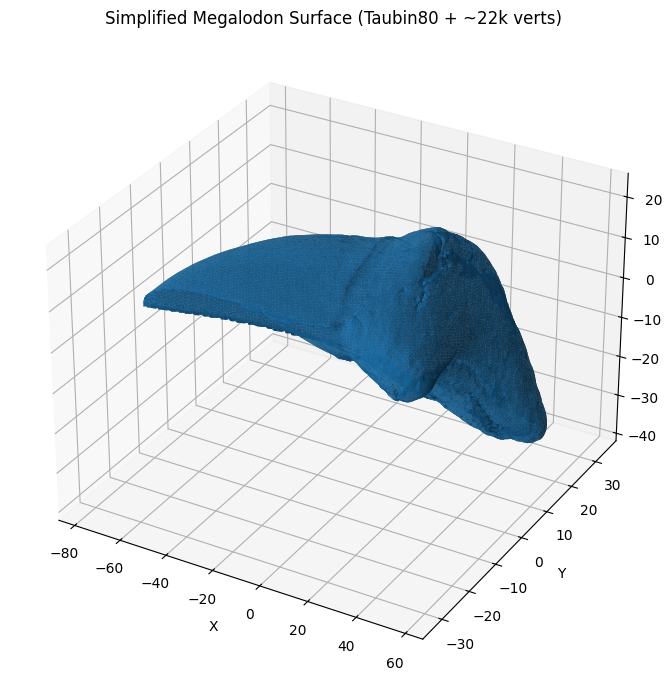

Exported: STL / PLY / MSH ✓


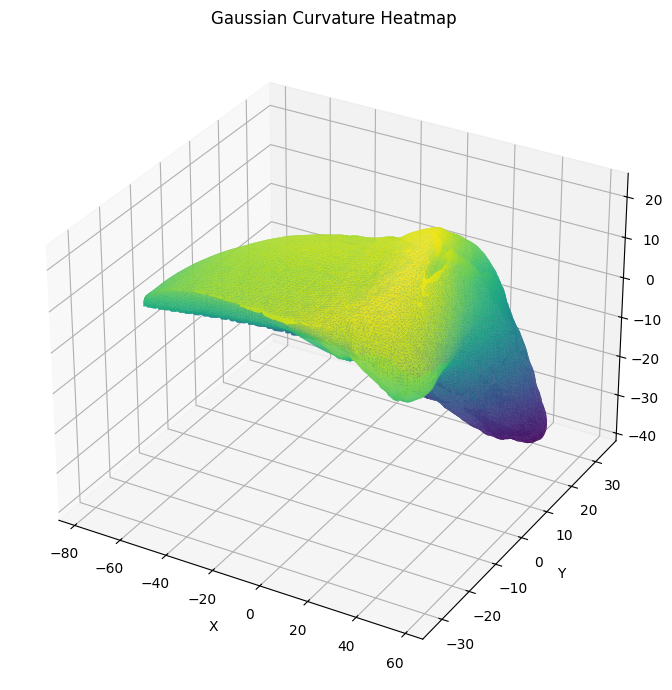

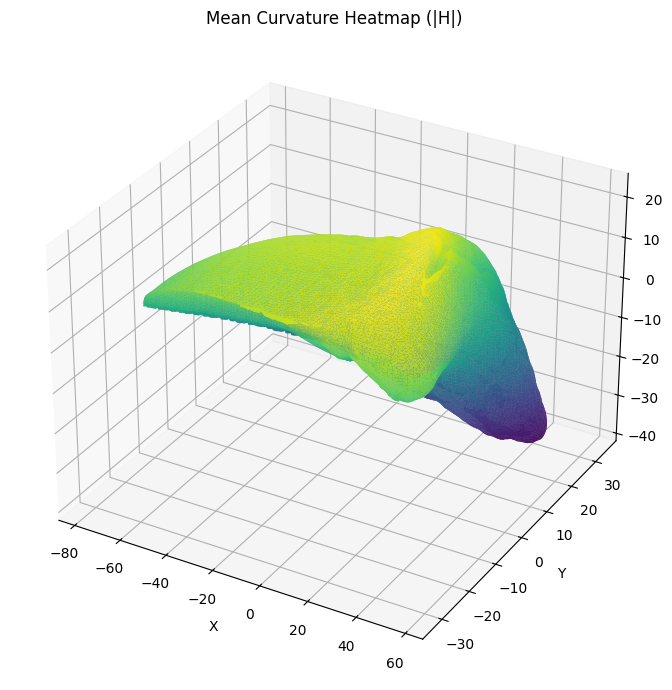

TetWild input OBJ generated: tetwild_input.obj ✓
Running TetWild refinement and tetrahedralization…
Starting tetrahedralization process...
Starting tetrahedralization...
Tetrahedralization complete.Loading mesh...
Loaded mesh data into GEO::Mesh.
Initialized AABBWrapper.
Created Mesh instance for output.
bbox_diag_length = 163.253
ideal_edge_length = 8.16266
stage = 2
eps_input = 0.163253
eps = 0.0903753
eps_simplification = 0.0723003
eps_coplanar = 0.000163253
dd = 0.108835
dd_simplification = 0.0870684
[2025-12-31 23:15:25.222] [float-tetwild] [info] remove duplicates: 
[2025-12-31 23:15:25.222] [float-tetwild] [info] #v: 22093 -> 22093
[2025-12-31 23:15:25.222] [float-tetwild] [info] #f: 46970 -> 44810
collapsing 0.784897
swapping 0.0159126
[2025-12-31 23:15:26.034] [float-tetwild] [info] remove duplicates: 
[2025-12-31 23:15:26.034] [float-tetwild] [info] #v: 9302 -> 9302
[2025-12-31 23:15:26.034] [float-tetwild] [info] #f: 19252 -> 19251
[2025-12-31 23:15:26.034] [float-tetwild] [

Widget(value='<iframe src="http://localhost:51277/index.html?ui=P_0x16bf5ea50_0&reconnect=auto" class="pyvista…

Saved Gmsh file: Megalodon_tetwild.msh ✓
Saved VTK for Paraview ✓
Loaded Taubin80 smoothed full mesh:
  Vertices: (22093, 3)
  Faces   : (46970, 3)
Full-resolution mesh topology check:
  boundary edges   = 0
  non-manifold edges = 3285
Simplified mesh:
  Vertices: (20199, 3)
  Faces   : (45334, 3)
Simplified mesh topology check:
  boundary edges   = 0
  non-manifold edges = 3306
Curvature computed and saved ✓
Curvature computed and saved ✓ using gaussian_curvature & average_curvature
Exported: Megalodon_taubin80_simplified30k.msh


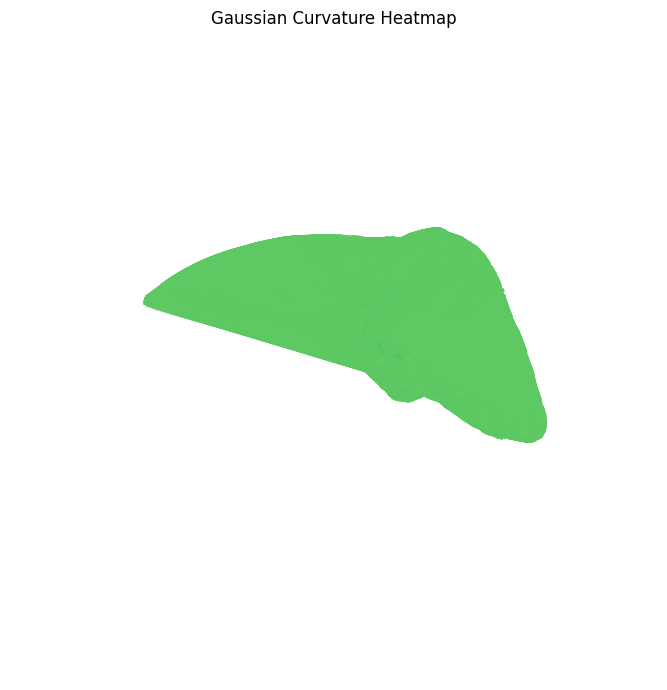

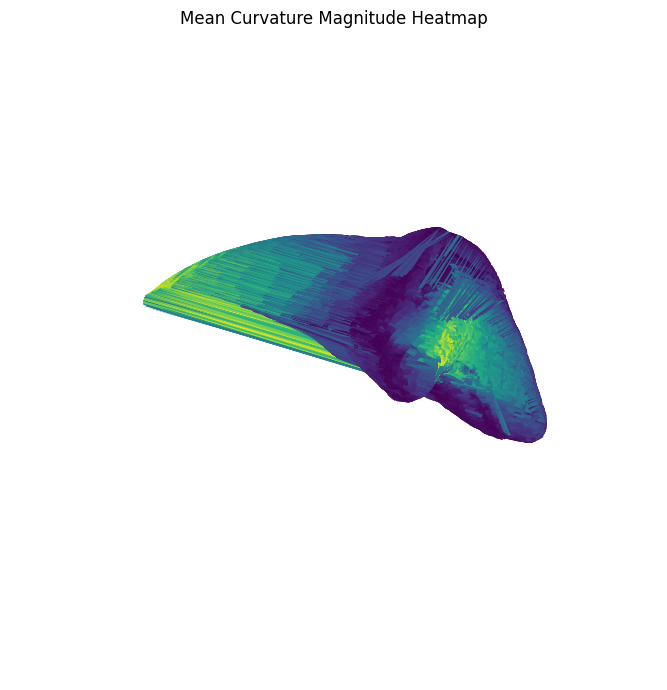

Delaunay faces: (40345, 3)


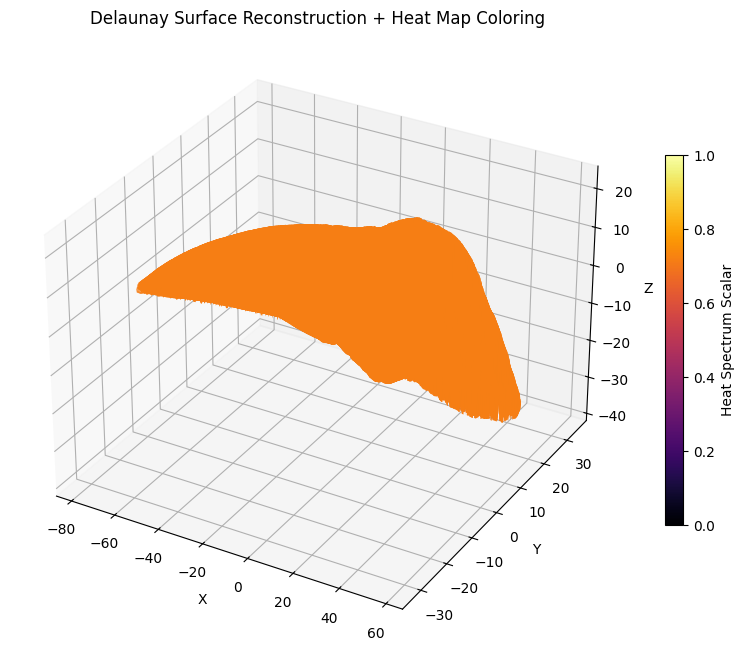

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# -----------------------------
# 配置：你的 Megalodon 模型路径
# -----------------------------
OBJ_PATH = "Megalodon.obj"   # 改成你的路径

def load_obj_vertices_faces(filename):
    """从 .obj 中读取 v 和 f，输出
       V: (N,3) 顶点坐标
       F: (M,3) 三角形顶点索引（0-based）
    """
    vertices = []
    faces = []
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("v "):
                parts = line.strip().split()
                vertices.append([float(parts[1]), float(parts[2]), float(parts[3])])
            elif line.startswith("f "):
                parts = line.strip().split()[1:]
                # 支持  v   或  v/vt/vn  格式，只取第一个数字
                idx = [int(p.split("/")[0]) for p in parts]
                # 假定原始为三角形；如果是多边形可以做简单扇形三角剖分
                if len(idx) == 3:
                    faces.append(idx)
                elif len(idx) > 3:
                    # 扇形剖分: (0, i, i+1)
                    for i in range(1, len(idx) - 1):
                        faces.append([idx[0], idx[i], idx[i+1]])

    V = np.array(vertices, dtype=float)
    F = np.array(faces, dtype=int) - 1  # 转成 0-based
    return V, F

V_full, F_full = load_obj_vertices_faces(OBJ_PATH)

print("Full mesh:")
print("  Vertices:", V_full.shape)
print("  Faces   :", F_full.shape)

# 如果你已经有 CSV，可替换为：
# V_full = np.loadtxt("Megalodon_vertices.csv", delimiter=",", skiprows=1)
# F_full = np.loadtxt("Megalodon_faces.csv", delimiter=",", skiprows=1, dtype=int) - 1

# ---------- Full mesh topology check ----------

edges01 = F_full[:, [0, 1]]
edges12 = F_full[:, [1, 2]]
edges20 = F_full[:, [2, 0]]
edges_full = np.vstack((edges01, edges12, edges20))

# 每条边排序端点，使 (i,j) 与 (j,i) 视为同一条
edges_sorted_full = np.sort(edges_full, axis=1)

edge_keys_full, edge_counts_full = np.unique(edges_sorted_full,
                                             axis=0,
                                             return_counts=True)

boundary_edges_full = int(np.sum(edge_counts_full == 1))
nonmanifold_edges_full = int(np.sum(edge_counts_full > 2))

print("Full mesh topology check:")
print("  Boundary edges   :", boundary_edges_full)
print("  Non-manifold edges:", nonmanifold_edges_full)

if boundary_edges_full == 0:
    print("  ✅ Watertight (no open boundary)")
else:
    print("  ⚠ 有开放边界")

if nonmanifold_edges_full == 0:
    print("  ✅ Manifold (no non-manifold edges)")
else:
    print("  ⚠ 存在非流形边")

# ---------- Build uniform adjacency matrix for Taubin smoothing ----------

N = V_full.shape[0]
rows = []
cols = []

for tri in F_full:
    a, b, c = tri
    rows.extend([a, b, b, c, c, a])
    cols.extend([b, a, c, b, a, c])

data = np.ones(len(rows), dtype=float)
A = coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()

deg = np.array(A.sum(axis=1)).ravel()
deg[deg == 0] = 1.0  # 防止除零

def taubin_smooth_sparse(V, A, deg, iters=80, lam=0.5, mu=-0.53):
    """
    Taubin smoothing:
      V_{k+1} = V_k + λ·L(V_k)  再   V_{k+2} = V_{k+1} + μ·L(V_{k+1})
    这里的 L 用 uniform Laplacian: L(V) = (A V / deg - V)
    iters = λ+μ 一起算一次，所以总 smoothing 回合 = iters
    """
    V = V.copy()
    for _ in range(iters):
        # lambda step
        AV = A.dot(V)
        LV = AV / deg[:, None] - V
        V = V + lam * LV

        # mu step
        AV = A.dot(V)
        LV = AV / deg[:, None] - V
        V = V + mu * LV
    return V

V_taubin = taubin_smooth_sparse(V_full, A, deg, iters=80, lam=0.5, mu=-0.53)

print("Taubin smoothing done. V_taubin shape:", V_taubin.shape)

# ---------- Higher-resolution simplification (~2–3 万顶点) ----------

V = V_taubin
F = F_full

n_axis = 80  # 80^3 体素，大概 2~3 万 cluster

mins = V.min(axis=0)
maxs = V.max(axis=0)
extent = maxs - mins
extent[extent == 0] = 1.0  # 防止除零

# 归一化到 [0,1)，然后映射到 0..n_axis-1
norm = (V - mins) / extent
idx = np.floor(norm * n_axis).astype(int)
idx = np.clip(idx, 0, n_axis - 1)

# 每个顶点对应一个体素线性编号
lin_idx = idx[:, 0] + idx[:, 1] * n_axis + idx[:, 2] * n_axis * n_axis

unique_cells, inverse = np.unique(lin_idx, return_inverse=True)
K = unique_cells.shape[0]

# 聚类平均每个cell内的顶点坐标
counts = np.bincount(inverse)
V30 = np.zeros((K, 3), dtype=float)
for d in range(3):
    V30[:, d] = np.bincount(inverse, weights=V[:, d]) / counts

# 重映射面索引
F30 = inverse[F]

# 去掉退化三角形
mask_non_deg = (F30[:, 0] != F30[:, 1]) & (F30[:, 1] != F30[:, 2]) & (F30[:, 0] != F30[:, 2])
F30 = F30[mask_non_deg]

print("Simplified mesh (for curvature / TetWild):")
print("  Vertices:", V30.shape)
print("  Faces   :", F30.shape)

# ---------- Orient faces consistently outward (approx) ----------

C30 = V30.mean(axis=0)   # 整体质心：用来判断“外侧”
v0 = V30[F30[:, 0]]
v1 = V30[F30[:, 1]]
v2 = V30[F30[:, 2]]

normals30 = np.cross(v1 - v0, v2 - v0)
centers30 = (v0 + v1 + v2) / 3.0
dirs30 = centers30 - C30

dots30 = np.einsum("ij,ij->i", normals30, dirs30)
flip_mask30 = dots30 < 0

# 将需要翻转的三角形交换第二、第三个顶点
tmp = F30[flip_mask30, 1].copy()
F30[flip_mask30, 1] = F30[flip_mask30, 2]
F30[flip_mask30, 2] = tmp

print("Face orientation unified (outward w.r.t mesh centroid).")

# ---------- Curvature analysis (Gaussian + mean curvature magnitude) ----------

nV = V30.shape[0]
nF = F30.shape[0]

p0 = V30[F30[:, 0]]
p1 = V30[F30[:, 1]]
p2 = V30[F30[:, 2]]

# 从各顶点出发的两条边向量
u0 = p1 - p0
v0 = p2 - p0
u1 = p2 - p1
v1 = p0 - p1
u2 = p0 - p2
v2 = p1 - p2

def angle_between(u, v):
    uu = np.linalg.norm(u, axis=1)
    vv = np.linalg.norm(v, axis=1)
    denom = uu * vv
    denom[denom == 0] = 1e-12
    cosang = np.einsum("ij,ij->i", u, v) / denom
    cosang = np.clip(cosang, -1.0, 1.0)
    return np.arccos(cosang)

ang0 = angle_between(u0, v0)
ang1 = angle_between(u1, v1)
ang2 = angle_between(u2, v2)

# 面面积
face_normals = np.cross(p1 - p0, p2 - p0)
face_areas = 0.5 * np.linalg.norm(face_normals, axis=1)

# 顶点角度和 & 顶点面积（1/3 分摊每个三角形到三个顶点）
angle_sum = np.zeros(nV)
area_sum = np.zeros(nV)

angle_sum += np.bincount(F30[:, 0], weights=ang0, minlength=nV)
angle_sum += np.bincount(F30[:, 1], weights=ang1, minlength=nV)
angle_sum += np.bincount(F30[:, 2], weights=ang2, minlength=nV)

area_sum += np.bincount(F30[:, 0], weights=face_areas / 3.0, minlength=nV)
area_sum += np.bincount(F30[:, 1], weights=face_areas / 3.0, minlength=nV)
area_sum += np.bincount(F30[:, 2], weights=face_areas / 3.0, minlength=nV)

area_safe = np.where(area_sum == 0, 1e-12, area_sum)

K_gauss = (2.0 * np.pi - angle_sum) / area_safe  # 高斯曲率

# Mean curvature via uniform Laplacian
rows = []
cols = []
for tri in F30:
    a, b, c = tri
    rows.extend([a, b, b, c, c, a])
    cols.extend([b, a, c, b, a, c])

data = np.ones(len(rows), dtype=float)
A30 = coo_matrix((data, (rows, cols)), shape=(nV, nV)).tocsr()
deg30 = np.array(A30.sum(axis=1)).ravel()
deg30[deg30 == 0] = 1.0

AV30 = A30.dot(V30)
L30 = AV30 / deg30[:, None] - V30
H_mean_mag = 0.5 * np.linalg.norm(L30, axis=1)

print("Curvature arrays:")
print("  K_gauss shape     :", K_gauss.shape)
print("  H_mean_magnitude  :", H_mean_mag.shape)

# 只做一个几何可视化：simplified Megalodon surface
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection="3d")

# 直接用 trisurf 看 simplified megalodon surface
ax.plot_trisurf(V30[:, 0], V30[:, 1], V30[:, 2],
                triangles=F30,
                linewidth=0.05,
                antialiased=True,
                shade=True,
                edgecolor="none",
                alpha=0.95)

ax.set_title("Simplified Megalodon Surface (Taubin80 + ~22k verts)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()

# ========== Export functions ==========

def export_stl_ascii(path, V, F):
    """ASCII STL export"""
    with open(path, "w") as f:
        f.write("solid mesh\n")
        for tri in F:
            p0, p1, p2 = V[tri]
            n = np.cross(p1 - p0, p2 - p0)
            n = n / (np.linalg.norm(n) + 1e-12)
            f.write(f"  facet normal {n[0]} {n[1]} {n[2]}\n")
            f.write("    outer loop\n")
            for p in (p0, p1, p2):
                f.write(f"      vertex {p[0]} {p[1]} {p[2]}\n")
            f.write("    endloop\n")
            f.write("  endfacet\n")
        f.write("endsolid mesh\n")


def export_ply(path, V, F):
    """PLY (ASCII) export"""
    with open(path, "w") as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {V.shape[0]}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write(f"element face {F.shape[0]}\n")
        f.write("property list uchar int vertex_indices\n")
        f.write("end_header\n")
        for p in V:
            f.write(f"{p[0]} {p[1]} {p[2]}\n")
        for tri in F:
            f.write(f"3 {tri[0]} {tri[1]} {tri[2]}\n")


def export_msh(path, V, F):
    """Gmsh v2 ASCII mesh (surface-only)"""
    with open(path, "w") as f:
        f.write("$MeshFormat\n2.2 0 8\n$EndMeshFormat\n")
        f.write("$Nodes\n")
        f.write(f"{V.shape[0]}\n")
        for i, p in enumerate(V, start=1):
            f.write(f"{i} {p[0]} {p[1]} {p[2]}\n")
        f.write("$EndNodes\n")

        f.write("$Elements\n")
        f.write(f"{F.shape[0]}\n")
        for i, tri in enumerate(F, start=1):
            f.write(f"{i} 2 2 1 1 {tri[0]+1} {tri[1]+1} {tri[2]+1}\n")
        f.write("$EndElements\n")


# ---- Export all three formats ----
export_stl_ascii("Megalodon_simplified.stl", V30, F30)
export_ply("Megalodon_simplified.ply", V30, F30)
export_msh("Megalodon_simplified.msh", V30, F30)

print("Exported: STL / PLY / MSH ✓")

# -------- Heatmap visualization on simplified surface ----------
from matplotlib import cm

def plot_surface_color(V, F, values, title):
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_trisurf(
        V[:, 0], V[:, 1], V[:, 2],
        triangles=F,
        linewidth=0.2,
        antialiased=True,
        cmap=cm.viridis,
        shade=False,
        edgecolor="none",
        alpha=0.95,
        facecolors=cm.viridis((values - values.min()) /
                              (values.max() - values.min() + 1e-12))
    )
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()


plot_surface_color(V30, F30, K_gauss, "Gaussian Curvature Heatmap")
plot_surface_color(V30, F30, H_mean_mag, "Mean Curvature Heatmap (|H|)")

# -------- Prepare TetWild input OBJ --------
with open("tetwild_input.obj", "w") as f:
    for p in V30:
        f.write(f"v {p[0]} {p[1]} {p[2]}\n")
    for tri in F30:
        f.write(f"f {tri[0]+1} {tri[1]+1} {tri[2]+1}\n")

print("TetWild input OBJ generated: tetwild_input.obj ✓")

import numpy as np
import pytetwild

# Input: your cleaned / simplified Megalodon surface
V_in = V30.astype(np.float64)
F_in = F30.astype(np.int32)

print("Running TetWild refinement and tetrahedralization…")

V_tet, T_tet = pytetwild.tetrahedralize(V_in, F_in)

print("TetWild tetrahedral mesh generated ✓")
print("  Vertices:", V_tet.shape)
print("  Tets    :", T_tet.shape)

import pyvista as pv
import numpy as np

# -------------------------
# Convert surface mesh
# -------------------------
# PolyData requires the VTK face format: [n, i0, i1, i2]
faces_vtk = np.hstack(
    [np.full((F_in.shape[0], 1), 3, dtype=np.int32), F_in]
).ravel()

surface_mesh = pv.PolyData(V_in, faces_vtk)


# -------------------------
# Convert tetrahedral mesh
# -------------------------
# UnstructuredGrid requires an offset + cell type array
# VTK tetra type = 10
num_tets = T_tet.shape[0]
cells = np.hstack(
    [np.full((num_tets, 1), 4, dtype=np.int32), T_tet]
).ravel()

celltypes = np.full(num_tets, 10, dtype=np.uint8)

tetrahedral_mesh = pv.UnstructuredGrid(cells, celltypes, V_tet)


# -------------------------
# PyVista visualization
# -------------------------
p = pv.Plotter(shape=(1, 2), border=False)

# --- Left: Input surface mesh ---
p.subplot(0, 0)
p.add_text("Input Surface Mesh", font_size=12)

p.add_mesh(
    surface_mesh,
    color="white",
    opacity=0.25,        # semi-transparent
    show_edges=True,
    edge_color="black",  
    line_width=0.3,      # extremely thin edge lines
    lighting=True,
    smooth_shading=True
)

# --- Right: TetWild tetrahedral mesh ---
p.subplot(0, 1)
p.add_text("TetWild Tetrahedral Mesh", font_size=12)

p.add_mesh(
    tetrahedral_mesh,
    color="lightblue",
    opacity=0.18,        # slightly more transparent for volume
    show_edges=True,
    edge_color="navy",
    line_width=0.25,     # even thinner edges for dense tets
    lighting=True,
    smooth_shading=True
)

# Sync cameras
p.link_views()
p.disable_parallel_projection()

p.show()

def write_msh(V, T, filename="Megalodon_tetwild.msh"):
    with open(filename, "w") as f:
        f.write("$MeshFormat\n2.2 0 8\n$EndMeshFormat\n")

        # Nodes
        f.write("$Nodes\n")
        f.write(f"{len(V)}\n")
        for i,(x,y,z) in enumerate(V, start=1):
            f.write(f"{i} {x} {y} {z}\n")
        f.write("$EndNodes\n")

        # Elements (4-node tetrahedra -> type 4)
        f.write("$Elements\n")
        f.write(f"{len(T)}\n")
        for i,(a,b,c,d) in enumerate(T+1, start=1):
            f.write(f"{i} 4 0 {a} {b} {c} {d}\n")
        f.write("$EndElements\n")

    print(f"Saved Gmsh file: {filename} ✓")

write_msh(V_tet, T_tet)

import meshio

meshio.write_points_cells(
    "Megalodon_tetwild.vtk",
    V_tet,
    {"tetra": T_tet}
)

print("Saved VTK for Paraview ✓")

import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

# -----------------------------
# 输入文件：你的 Taubin80 平滑结果
# -----------------------------
# save V_30 and F_30 in npz format in Megalodon_vertices_taubin80.csv and Megalodon_faces.csv
import numpy as np
import os, zipfile, tempfile

def safe_npz_write(path, **arrays):
    """Safe NPZ writer that avoids NumPy compression bugs on macOS/Python 3.13."""
    path = os.path.abspath(path)
    folder = os.path.dirname(path)
    if folder and not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)

    tmp = path + ".tmp"

    try:
        # write manually as ZIP
        with zipfile.ZipFile(tmp, "w", zipfile.ZIP_DEFLATED) as zf:
            for name, arr in arrays.items():
                arr = np.asarray(arr)
                # store as NPY inside the zip
                with zf.open(name + ".npy", "w") as f:
                    np.save(f, arr)
    except Exception as e:
        raise RuntimeError(f"Error during NPZ write: {e}")

    if not os.path.exists(tmp):
        raise RuntimeError("Temp NPZ was not created — write failed.")

    os.replace(tmp, path)


# ------------------------------------------------------------
# Usage
# ------------------------------------------------------------

safe_npz_write(
    "/Users/eliguli712/DataStructure/numerical_analysis/FEA_meg/Megalodon_mesh_backup.npz",
    V=V30,
    F=F30
)

V_full = np.loadtxt("Megalodon_vertices_taubin80.csv", delimiter=",", skiprows=1)
F_full = np.loadtxt("Megalodon_faces.csv", delimiter=",", skiprows=1, dtype=int) - 1

print("Loaded Taubin80 smoothed full mesh:")
print("  Vertices:", V_full.shape)
print("  Faces   :", F_full.shape)

# ---------- Construct edges ----------
edges01 = F_full[:, [0, 1]]
edges12 = F_full[:, [1, 2]]
edges20 = F_full[:, [2, 0]]
edges_full = np.vstack((edges01, edges12, edges20))

edges_sorted = np.sort(edges_full, axis=1)
edge_keys, edge_counts = np.unique(edges_sorted, axis=0, return_counts=True)

boundary_edges_full = int(np.sum(edge_counts == 1))
nonmanifold_edges_full = int(np.sum(edge_counts > 2))

print("Full-resolution mesh topology check:")
print("  boundary edges   =", boundary_edges_full)
print("  non-manifold edges =", nonmanifold_edges_full)

def voxel_simplify(V, F, n_axis=80):
    mins = V.min(axis=0)
    maxs = V.max(axis=0)
    extent = maxs - mins
    extent[extent == 0] = 1.0

    norm = (V - mins) / extent
    idx = np.floor(norm * n_axis).astype(int)
    idx = np.clip(idx, 0, n_axis-1)

    lin_idx = idx[:, 0] + idx[:, 1]*n_axis + idx[:, 2]*(n_axis*n_axis)

    unique_cells, inverse = np.unique(lin_idx, return_inverse=True)
    K = unique_cells.shape[0]

    # 生成聚类顶点
    V_new = np.zeros((K, 3))
    counts = np.bincount(inverse)

    for d in range(3):
        V_new[:, d] = np.bincount(inverse, weights=V[:, d]) / counts

    # 重新映射面
    F_new = inverse[F]

    # 删除退化面
    mask = (F_new[:,0]!=F_new[:,1]) & (F_new[:,1]!=F_new[:,2]) & (F_new[:,0]!=F_new[:,2])
    return V_new, F_new[mask]

V30, F30 = voxel_simplify(V_full, F_full, n_axis=80)

print("Simplified mesh:")
print("  Vertices:", V30.shape)
print("  Faces   :", F30.shape)

edges01 = F30[:, [0, 1]]
edges12 = F30[:, [1, 2]]
edges20 = F30[:, [2, 0]]
edges = np.vstack((edges01, edges12, edges20))

edges_sorted = np.sort(edges, axis=1)
ek, ec = np.unique(edges_sorted, axis=0, return_counts=True)

boundary_edges_30 = int(np.sum(ec == 1))
nonmanifold_edges_30 = int(np.sum(ec > 2))

print("Simplified mesh topology check:")
print("  boundary edges   =", boundary_edges_30)
print("  non-manifold edges =", nonmanifold_edges_30)

import numpy as np

# Helper: Compute face angles
def angle(a, b, c):
    u = b - a
    v = c - a
    cosang = np.sum(u * v, axis=1) / (
        np.linalg.norm(u, axis=1) * np.linalg.norm(v, axis=1) + 1e-15
    )
    return np.arccos(np.clip(cosang, -1.0, 1.0))

def mixed_voronoi(V, F):
    """
    Compute mixed Voronoi area per vertex for a triangulated surface mesh.
    Meyer–Desbrun–Schröder–Barr (2003) formula.
    """
    V = np.asarray(V)
    F = np.asarray(F)

    # Face vertex positions
    v0 = V[F[:, 0]]
    v1 = V[F[:, 1]]
    v2 = V[F[:, 2]]

    # Edge vectors
    e0 = v1 - v0  # edge v0→v1
    e1 = v2 - v1  # edge v1→v2
    e2 = v0 - v2  # edge v2→v0 (note sign is ok)

    # Opposite edge lengths
    l0 = np.linalg.norm(e0, axis=1)
    l1 = np.linalg.norm(e1, axis=1)
    l2 = np.linalg.norm(e2, axis=1)

    A0 = angle(v0, v1, v2)
    A1 = angle(v1, v2, v0)
    A2 = angle(v2, v0, v1)

    # Triangle area
    face_area = 0.5 * np.linalg.norm(np.cross(e0, e2), axis=1)

    # Detect obtuse triangles
    obt0 = A0 > np.pi/2
    obt1 = A1 > np.pi/2
    obt2 = A2 > np.pi/2
    any_obt = obt0 | obt1 | obt2

    # Cotangents (used if triangle is non-obtuse)
    cot0 = 1 / np.tan(A0)
    cot1 = 1 / np.tan(A1)
    cot2 = 1 / np.tan(A2)

    # Mixed Voronoi per face, contributions to v0, v1, v2
    area0 = np.zeros(len(F))
    area1 = np.zeros(len(F))
    area2 = np.zeros(len(F))

    # Case 1: non-obtuse triangle → use standard cotangent Voronoi
    mask = ~any_obt
    area0[mask] = (l2[mask]**2 * cot1[mask] + l1[mask]**2 * cot2[mask]) * 0.125
    area1[mask] = (l0[mask]**2 * cot2[mask] + l2[mask]**2 * cot0[mask]) * 0.125
    area2[mask] = (l1[mask]**2 * cot0[mask] + l0[mask]**2 * cot1[mask]) * 0.125

    # Case 2: obtuse triangle → area split special-case
    area0[obt0] = face_area[obt0] * 0.5
    area1[obt0] = face_area[obt0] * 0.25
    area2[obt0] = face_area[obt0] * 0.25

    area1[obt1] = face_area[obt1] * 0.5
    area2[obt1] = face_area[obt1] * 0.25
    area0[obt1] = face_area[obt1] * 0.25

    area2[obt2] = face_area[obt2] * 0.5
    area0[obt2] = face_area[obt2] * 0.25
    area1[obt2] = face_area[obt2] * 0.25

    # Assemble per-vertex Voronoi area
    A = np.zeros(len(V))
    np.add.at(A, F[:, 0], area0)
    np.add.at(A, F[:, 1], area1)
    np.add.at(A, F[:, 2], area2)

    return A

def gaussian_curvature(V, F):
    """
    Compute Gaussian curvature (angle deficit) per vertex
    using mixed Voronoi areas (Meyer et al. 2003).
    """
    V = np.asarray(V)
    F = np.asarray(F)

    # Face vertex positions
    p0 = V[F[:, 0]]
    p1 = V[F[:, 1]]
    p2 = V[F[:, 2]]

    A0 = angle(p0, p1, p2)
    A1 = angle(p1, p2, p0)
    A2 = angle(p2, p0, p1)

    # ----- accumulate per-vertex angle sums -----
    angle_sum = np.zeros(len(V))
    np.add.at(angle_sum, F[:, 0], A0)
    np.add.at(angle_sum, F[:, 1], A1)
    np.add.at(angle_sum, F[:, 2], A2)

    # ----- per-vertex Voronoi area -----
    A_mixed = mixed_voronoi(V, F)

    # ----- Gaussian curvature -----
    K = (2 * np.pi - angle_sum) / (A_mixed + 1e-12)

    return K

def average_curvature(V, F):
    """
    Mean curvature magnitude per vertex using the cotangent Laplacian.
    From Meyer et al. 2003 (the standard discrete differential geometry formula).
    """
    V = np.asarray(V, float)
    F = np.asarray(F, int)

    # Face vertex positions
    p0 = V[F[:, 0]]
    p1 = V[F[:, 1]]
    p2 = V[F[:, 2]]

    # Edge vectors
    e0 = p2 - p1   # opposite p0
    e1 = p0 - p2   # opposite p1
    e2 = p1 - p0   # opposite p2

    # Compute cotangents
    def cotangent(u, v):
        cross = np.linalg.norm(np.cross(u, v), axis=1)
        dot   = np.sum(u * v, axis=1)
        return dot / (cross + 1e-15)

    cot0 = cotangent(p1 - p0, p2 - p0)
    cot1 = cotangent(p2 - p1, p0 - p1)
    cot2 = cotangent(p0 - p2, p1 - p2)

    # Mixed Voronoi area per vertex (Meyer et al.)
    A = mixed_voronoi(V, F)

    # Accumulate Laplacian (cotangent-weighted)
    L = np.zeros_like(V)

    # For each face, accumulate contributions for the three vertices
    for i, tri in enumerate(F):
        i0, i1, i2 = tri
        c0, c1, c2 = cot0[i], cot1[i], cot2[i]

        # Laplace-Beltrami operator contributions
        L[i0] += (c1 * (V[i2] - V[i0]) + c2 * (V[i1] - V[i0]))
        L[i1] += (c2 * (V[i0] - V[i1]) + c0 * (V[i2] - V[i1]))
        L[i2] += (c0 * (V[i1] - V[i2]) + c1 * (V[i0] - V[i2]))

    # Mean curvature normal: Hn = 1/(2A) L
    H_normal = L / (2.0 * A[:, None] + 1e-15)

    # Mean curvature magnitude |H|
    H_mean_mag = np.linalg.norm(H_normal, axis=1)

    return H_mean_mag

def principal_curvatures(V, F):
    """
    Compute principal curvature magnitudes k1, k2 per vertex.

    Uses:
      - K: Gaussian curvature from angle deficit / mixed Voronoi
      - H: mean curvature magnitude from cotangent Laplacian

    Note: average_curvature currently returns |H|, so k1, k2 are
    magnitudes (non-signed) consistent with |H| and K.
    """
    K = gaussian_curvature(V, F)      # Gaussian curvature per vertex
    H = average_curvature(V, F)       # mean curvature magnitude per vertex

    # Discriminant: H^2 - K, clipped for numerical safety
    disc = H * H - K
    disc = np.clip(disc, 0.0, None)

    sqrt_disc = np.sqrt(disc)
    k1 = H + sqrt_disc
    k2 = H - sqrt_disc

    return k1, k2
    
import numpy as np
from scipy.sparse import coo_matrix

# =============================================================
#   ANGLE-DEFICIT GAUSSIAN CURVATURE (your exact method)
# =============================================================

# Triangle vertex positions
p0 = V30[F30[:, 0]]
p1 = V30[F30[:, 1]]
p2 = V30[F30[:, 2]]

def tri_angle(a, b, c):
    """
    Angle at 'b' in triangle (a, b, c)
    """
    ba = a - b
    bc = c - b
    dot = np.einsum("ij,ij->i", ba, bc)
    n1  = np.linalg.norm(ba, axis=1)
    n2  = np.linalg.norm(bc, axis=1)
    cosv = dot / (n1 * n2 + 1e-15)
    return np.arccos(np.clip(cosv, -1.0, 1.0))

# Angles at vertices
ang0 = tri_angle(p1, p0, p2)   # angle at p0
ang1 = tri_angle(p2, p1, p0)   # angle at p1
ang2 = tri_angle(p0, p2, p1)   # angle at p2

# Face areas
face_normals = np.cross(p1 - p0, p2 - p0)
face_areas   = 0.5 * np.linalg.norm(face_normals, axis=1)

nV = len(V30)

# ----- Accumulate angle sum per vertex -----
angle_sum = (
    np.bincount(F30[:,0], weights=ang0, minlength=nV)
  + np.bincount(F30[:,1], weights=ang1, minlength=nV)
  + np.bincount(F30[:,2], weights=ang2, minlength=nV)
)

# ----- Accumulate area sum per vertex -----
area_third = face_areas / 3.0
area_sum = (
    np.bincount(F30[:,0], weights=area_third, minlength=nV)
  + np.bincount(F30[:,1], weights=area_third, minlength=nV)
  + np.bincount(F30[:,2], weights=area_third, minlength=nV)
)

# Gaussian curvature from angle deficit
K_gauss = (2.0*np.pi - angle_sum) / (area_sum + 1e-12)



# =============================================================
#   MEAN CURVATURE VIA UNIFORM GRAPH LAPLACIAN (your method)
# =============================================================

# Build adjacency from edges (a,b), (b,c), (c,a)
rows = []
cols = []
for tri in F30:
    a, b, c = tri
    rows += [a, b, b, c, c, a]
    cols += [b, a, c, b, a, c]

# Sparse vertex-vertex adjacency
A = coo_matrix(
    (np.ones(len(rows)), (rows, cols)),
    shape=(nV, nV)
).tocsr()

# Degree vector
deg = np.array(A.sum(axis=1)).ravel()
deg[deg == 0] = 1.0   # avoid divide-by-zero

# Uniform Laplacian: ΔV = average(neighbors) – V
AV = A.dot(V30)
L  = AV / deg[:, None] - V30

# Mean curvature magnitude:  |H| = 0.5 * |ΔV|
H_mean_mag = 0.5 * np.linalg.norm(L, axis=1)



# =============================================================
#   SAVE RESULT
# =============================================================

curv = np.column_stack([K_gauss, H_mean_mag])

np.savetxt(
    "Megalodon_simplified_curvature_K_H.csv",
    curv,
    delimiter=",",
    header="K_gaussian,H_mean",
    comments=''
)

print("Curvature computed and saved ✓")

import numpy as np

# -------------------------------------------------------------
# Compute curvatures using your existing definitions
# -------------------------------------------------------------
K = gaussian_curvature(V30, F30)          # angle deficit / mixed Voronoi
H = average_curvature(V30, F30)           # |mean curvature| from cotangent LB
k1, k2 = principal_curvatures(V30, F30)   # principal curvature magnitudes

# -------------------------------------------------------------
# Stack and save results
# -------------------------------------------------------------
curv = np.column_stack([K, H])
np.savetxt(
    "Megalodon_simplified_curvature_K_H.csv",
    curv,
    delimiter=",",
    header="K_gaussian,H_mean",
    comments=""
) # "Megalodon_curvature_K_H.csv"

print("Curvature computed and saved ✓ using gaussian_curvature & average_curvature")

msh_path = "Megalodon_taubin80_simplified30k.msh"

with open(msh_path, "w") as f:
    f.write("$MeshFormat\n2.2 0 8\n$EndMeshFormat\n")
    
    # Nodes
    f.write("$Nodes\n")
    f.write(f"{V30.shape[0]}\n")
    for i,p in enumerate(V30,1):
        f.write(f"{i} {p[0]} {p[1]} {p[2]}\n")
    f.write("$EndNodes\n")

    # Triangles
    f.write("$Elements\n")
    f.write(f"{F30.shape[0]}\n")
    for i,tri in enumerate(F30,1):
        f.write(f"{i} 2 2 1 1 {tri[0]+1} {tri[1]+1} {tri[2]+1}\n")
    f.write("$EndElements\n")

print("Exported:", msh_path)

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def plot_color_surface(V, F, values, title):
    # ---- Compute per-face values ----
    face_vals = values[F].mean(axis=1)
    c = (face_vals - face_vals.min()) / (face_vals.max() - face_vals.min() + 1e-12)
    face_colors = cm.viridis(c)

    # ---- Build face geometry ----
    faces_xyz = V[F]  # shape (n_faces, 3, 3)

    # ---- Plot ----
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection='3d')

    poly = Poly3DCollection(faces_xyz, facecolors=face_colors, linewidth=0.0)
    poly.set_edgecolor((0, 0, 0, 0))  # fully transparent edges
    ax.add_collection3d(poly)

    # autoscale
    ax.auto_scale_xyz(V[:, 0], V[:, 1], V[:, 2])
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


# ---- Run it ----
plot_color_surface(V30, F30, K_gauss, "Gaussian Curvature Heatmap")
plot_color_surface(V30, F30, H_mean_mag, "Mean Curvature Magnitude Heatmap")

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from mpl_toolkits.mplot3d import Axes3D

# -----------------------------
# 使用 Delaunay 在 XY 平面重新构造三角网格
# -----------------------------
xy = V30[:, :2]               # 只用 xy 投影做 2D Delaunay
tri = Delaunay(xy)
F_delaunay = tri.simplices    # (M,3) 新的三角面

print("Delaunay faces:", F_delaunay.shape)

# -----------------------------
# 准备颜色标量（你可以使用 K_gauss 或 H_mean_mag）
# 例：按曲率着色
# -----------------------------
# scalar = K_gauss                # 如果你有高斯曲率
# scalar = H_mean_mag             # 如果你有平均曲率
scalar = np.linalg.norm(V30, axis=1)   # 例：按点半径着色 (默认)

# 归一化到 [0,1]
scalar_norm = (scalar - scalar.min()) / (scalar.max() - scalar.min())

# -----------------------------
# 绘制带 heat colormap 的 Delaunay 曲面
# -----------------------------
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

trisurf = ax.plot_trisurf(
    V30[:, 0], V30[:, 1], V30[:, 2],
    triangles=F_delaunay,
    cmap="inferno",           # 🔥 heat spectrum
    antialiased=True,
    linewidth=0.0,
    edgecolor='none',
    shade=False,              # 关掉 shade，否则 colormap 会被 wash-out
    alpha=1.0
)

# 将顶点颜色映射到 trisurf
trisurf.set_array(scalar_norm)
trisurf.autoscale()

ax.set_title("Delaunay Surface Reconstruction + Heat Map Coloring")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.colorbar(trisurf, ax=ax, shrink=0.6, label="Heat Spectrum Scalar")
plt.show()


#### Graph Laplace and Mean Curvature Uniform Laplacian
The Uniform Laplacian is given by
$$\Delta V \approx \frac{1}{\deg(i)}\sum_{j\in N(i)} V_j - V_i$$
which is not the geometric Laplacian
##### Mean Curvature as Cotan Laplacian + Mixed Voronoi Area
$$\mathbf{H}_n(i) = \frac{1}{2A_i}\sum_{j\in N(i)}(\cot\alpha_{ij} + \cot\beta_{ij})(V_j - V_i), \qquad |H| = \frac{1}{2}\|\mathbf{H}_n\|$$
where $\mathbf{H}_n$ is mean curvature normal vector, $\|\mathbf{H}_n\|$ is mean curvature magnitude, $A_i$ is calculated by mixed Voronoi area (or 1-ring barycentric area, alternatively, Voronoi has more numerical stability)

In [8]:
import numpy as np

# ---------- helpers ----------
def angle(a, b, c):
    u = b - a
    v = c - a
    cosang = np.sum(u * v, axis=1) / (np.linalg.norm(u, axis=1) * np.linalg.norm(v, axis=1) + 1e-15)
    return np.arccos(np.clip(cosang, -1.0, 1.0))

def mixed_voronoi(V, F):
    V = np.asarray(V, float)
    F = np.asarray(F, int)

    v0 = V[F[:, 0]]
    v1 = V[F[:, 1]]
    v2 = V[F[:, 2]]

    e0 = v1 - v0
    e1 = v2 - v1
    e2 = v0 - v2

    l0 = np.linalg.norm(e0, axis=1)
    l1 = np.linalg.norm(e1, axis=1)
    l2 = np.linalg.norm(e2, axis=1)

    A0 = angle(v0, v1, v2)
    A1 = angle(v1, v2, v0)
    A2 = angle(v2, v0, v1)

    face_area = 0.5 * np.linalg.norm(np.cross(e0, -e2), axis=1)

    obt0 = A0 > np.pi/2
    obt1 = A1 > np.pi/2
    obt2 = A2 > np.pi/2
    any_obt = obt0 | obt1 | obt2

    cot0 = 1.0 / (np.tan(A0) + 1e-15)
    cot1 = 1.0 / (np.tan(A1) + 1e-15)
    cot2 = 1.0 / (np.tan(A2) + 1e-15)

    area0 = np.zeros(len(F))
    area1 = np.zeros(len(F))
    area2 = np.zeros(len(F))

    mask = ~any_obt
    area0[mask] = (l2[mask]**2 * cot1[mask] + l1[mask]**2 * cot2[mask]) * 0.125
    area1[mask] = (l0[mask]**2 * cot2[mask] + l2[mask]**2 * cot0[mask]) * 0.125
    area2[mask] = (l1[mask]**2 * cot0[mask] + l0[mask]**2 * cot1[mask]) * 0.125

    area0[obt0] = face_area[obt0] * 0.5
    area1[obt0] = face_area[obt0] * 0.25
    area2[obt0] = face_area[obt0] * 0.25

    area1[obt1] = face_area[obt1] * 0.5
    area2[obt1] = face_area[obt1] * 0.25
    area0[obt1] = face_area[obt1] * 0.25

    area2[obt2] = face_area[obt2] * 0.5
    area0[obt2] = face_area[obt2] * 0.25
    area1[obt2] = face_area[obt2] * 0.25

    A = np.zeros(len(V))
    np.add.at(A, F[:, 0], area0)
    np.add.at(A, F[:, 1], area1)
    np.add.at(A, F[:, 2], area2)
    return A

def vertex_normals_area_weighted(V, F):
    V = np.asarray(V, float)
    F = np.asarray(F, int)
    FN = np.cross(V[F[:,1]] - V[F[:,0]], V[F[:,2]] - V[F[:,0]])  # area-weighted
    VN = np.zeros_like(V)
    np.add.at(VN, F[:,0], FN)
    np.add.at(VN, F[:,1], FN)
    np.add.at(VN, F[:,2], FN)
    VN /= (np.linalg.norm(VN, axis=1, keepdims=True) + 1e-15)
    return VN

# ---------- Gaussian curvature: angle deficit / mixed Voronoi ----------
def gaussian_curvature(V, F):
    V = np.asarray(V, float)
    F = np.asarray(F, int)

    p0 = V[F[:,0]]
    p1 = V[F[:,1]]
    p2 = V[F[:,2]]

    A0 = angle(p0, p1, p2)
    A1 = angle(p1, p2, p0)
    A2 = angle(p2, p0, p1)

    angle_sum = np.zeros(len(V))
    np.add.at(angle_sum, F[:,0], A0)
    np.add.at(angle_sum, F[:,1], A1)
    np.add.at(angle_sum, F[:,2], A2)

    A_mixed = mixed_voronoi(V, F)
    K = (2.0*np.pi - angle_sum) / (A_mixed + 1e-15)
    return K

# ---------- Mean curvature: cotangent formula (Meyer et al.) ----------
def mean_curvature(V, F, want_signed=True):
    V = np.asarray(V, float)
    F = np.asarray(F, int)
    nV = len(V)

    p0 = V[F[:,0]]
    p1 = V[F[:,1]]
    p2 = V[F[:,2]]

    def cotangent(u, v):
        # cot(theta) = dot(u,v)/||u×v||
        cross = np.linalg.norm(np.cross(u, v), axis=1)
        dot   = np.sum(u*v, axis=1)
        return dot / (cross + 1e-15)

    # cotangents at vertices (angles at p0, p1, p2)
    cot0 = cotangent(p1 - p0, p2 - p0)
    cot1 = cotangent(p2 - p1, p0 - p1)
    cot2 = cotangent(p0 - p2, p1 - p2)

    A = mixed_voronoi(V, F)

    # Accumulate L(V) directly (vector form)
    LV = np.zeros_like(V)
    # Using: for vertex i0, contributions from edges (i0-i1) and (i0-i2)
    for t in range(len(F)):
        i0, i1, i2 = F[t]
        c0, c1, c2 = cot0[t], cot1[t], cot2[t]
        LV[i0] += c1*(V[i2] - V[i0]) + c2*(V[i1] - V[i0])
        LV[i1] += c2*(V[i0] - V[i1]) + c0*(V[i2] - V[i1])
        LV[i2] += c0*(V[i1] - V[i2]) + c1*(V[i0] - V[i2])

    # Mean curvature normal vector:
    # Hn = (1/(2A)) * LV   (common discrete DDG convention)
    Hn = LV / (2.0*(A[:,None] + 1e-15))

    H_mag = np.linalg.norm(Hn, axis=1)

    if not want_signed:
        return Hn, H_mag

    VN = vertex_normals_area_weighted(V, F)
    sign = np.sign(np.einsum("ij,ij->i", Hn, VN))
    # If some are exactly 0, keep them 0
    H_signed = sign * H_mag

    return Hn, H_signed, H_mag

# ---------- Principal curvatures (need signed mean curvature!) ----------
def principal_curvatures(V, F):
    K = gaussian_curvature(V, F)
    _, H_signed, H_mag = mean_curvature(V, F, want_signed=True)

    # Use signed H here:
    disc = H_signed*H_signed - K
    disc = np.clip(disc, 0.0, None)
    s = np.sqrt(disc)

    k1 = H_signed + s
    k2 = H_signed - s
    return K, H_signed, H_mag, k1, k2

# ===== Usage =====
K, H_signed, H_mag, k1, k2 = principal_curvatures(V30, F30)
# Now H_mag and H_signed are DEFINITELY defined.

/var/folders/q1/xn03yx0d3lb4vlk97t91k1380000gn/T/ipykernel_45707/3155285778.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap(cmap_name)(t)


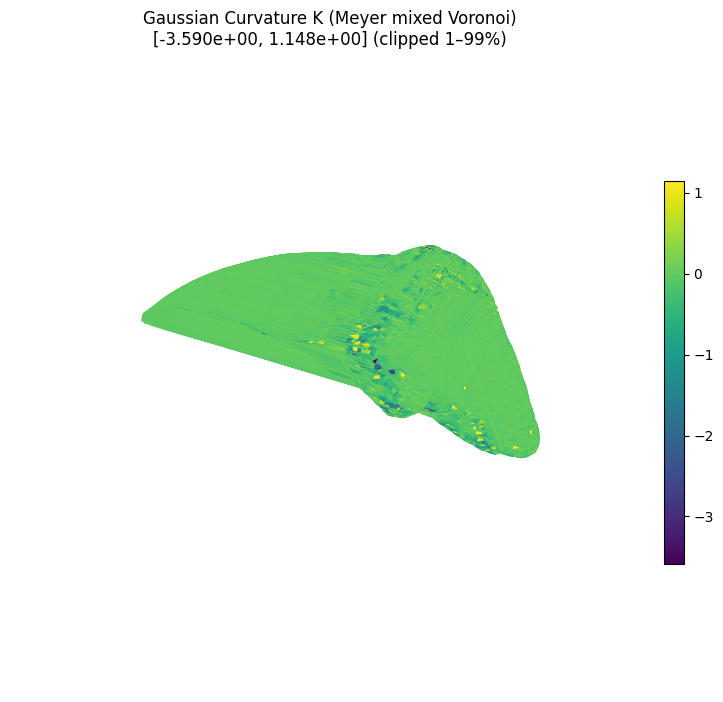

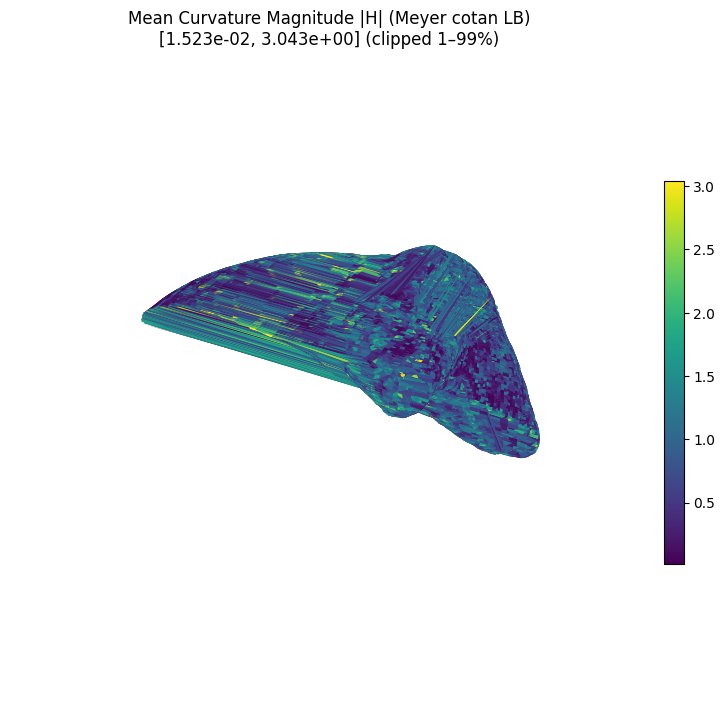

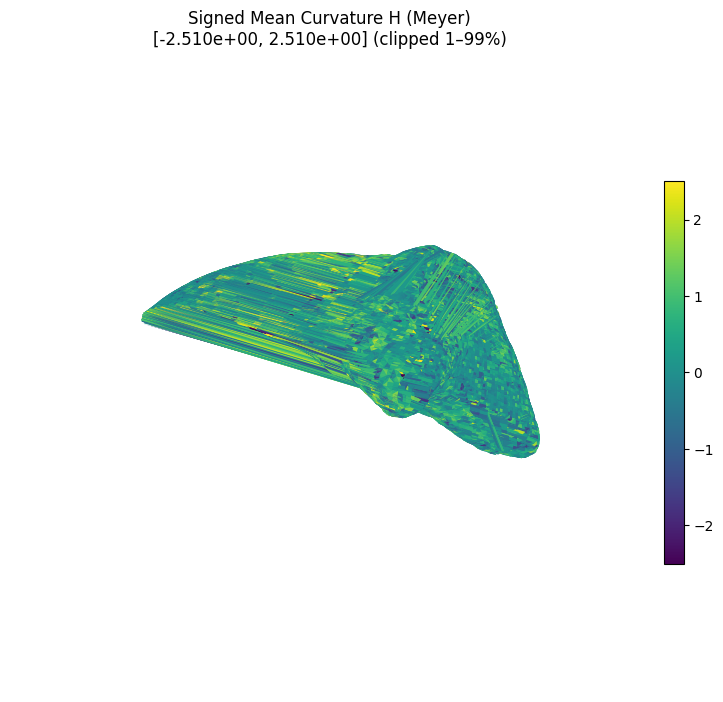

In [9]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def robust_norm(values, vmin=None, vmax=None, clip_percent=(1,99), symmetric=False):
    x = np.asarray(values, float)
    if vmin is None or vmax is None:
        lo, hi = np.percentile(x[np.isfinite(x)], clip_percent)
        if symmetric:
            m = max(abs(lo), abs(hi))
            lo, hi = -m, m
        vmin = lo if vmin is None else vmin
        vmax = hi if vmax is None else vmax
    t = (x - vmin) / (vmax - vmin + 1e-12)
    return np.clip(t, 0.0, 1.0), vmin, vmax

def plot_mesh_scalar(V, F, scalar_vertex, title, cmap_name="viridis",
                     clip_percent=(1,99), symmetric=False):
    # per-face scalar = mean of its vertices
    face_vals = scalar_vertex[F].mean(axis=1)

    t, vmin, vmax = robust_norm(face_vals, clip_percent=clip_percent, symmetric=symmetric)
    colors = cm.get_cmap(cmap_name)(t)

    faces_xyz = V[F]
    fig = plt.figure(figsize=(8,7))
    ax = fig.add_subplot(111, projection="3d")

    poly = Poly3DCollection(faces_xyz, facecolors=colors, linewidth=0.0)
    poly.set_edgecolor((0,0,0,0))
    ax.add_collection3d(poly)

    ax.auto_scale_xyz(V[:,0], V[:,1], V[:,2])
    ax.set_axis_off()
    ax.set_title(f"{title}\n[{vmin:.3e}, {vmax:.3e}] (clipped {clip_percent[0]}–{clip_percent[1]}%)")

    # scalar bar
    mappable = cm.ScalarMappable(cmap=cmap_name)
    mappable.set_array(face_vals)
    mappable.set_clim(vmin, vmax)
    plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.02)

    plt.tight_layout()
    plt.show()

# Examples:
plot_mesh_scalar(V30, F30, K_gauss, "Gaussian Curvature K (Meyer mixed Voronoi)")
plot_mesh_scalar(V30, F30, H_mag,   "Mean Curvature Magnitude |H| (Meyer cotan LB)")
plot_mesh_scalar(V30, F30, H_signed,"Signed Mean Curvature H (Meyer)", symmetric=True)

In [12]:
import numpy as np
from scipy.sparse import coo_matrix

def tri_angles(p0, p1, p2, eps=1e-15):
    # angles opposite each edge:
    # angle at p0 opposite edge (p1,p2)
    def angle(a, b, c):
        ba = a - b
        bc = c - b
        dot = np.einsum("ij,ij->i", ba, bc)
        n1 = np.linalg.norm(ba, axis=1)
        n2 = np.linalg.norm(bc, axis=1)
        cosv = dot / (n1*n2 + eps)
        return np.arccos(np.clip(cosv, -1.0, 1.0))
    ang0 = angle(p1, p0, p2)  # at p0
    ang1 = angle(p2, p1, p0)  # at p1
    ang2 = angle(p0, p2, p1)  # at p2
    return ang0, ang1, ang2

def vertex_mixed_area(V, F):
    # simple robust fallback: barycentric area (1/3 each incident face)
    p0 = V[F[:,0]]; p1 = V[F[:,1]]; p2 = V[F[:,2]]
    face_areas = 0.5 * np.linalg.norm(np.cross(p1-p0, p2-p0), axis=1)
    nV = V.shape[0]
    A = np.bincount(F[:,0], face_areas/3, minlength=nV) \
      + np.bincount(F[:,1], face_areas/3, minlength=nV) \
      + np.bincount(F[:,2], face_areas/3, minlength=nV)
    return A

def cotan_laplacian(V, F, eps=1e-15):
    nV = V.shape[0]
    p0 = V[F[:,0]]; p1 = V[F[:,1]]; p2 = V[F[:,2]]

    # angles at vertices
    ang0, ang1, ang2 = tri_angles(p0, p1, p2, eps=eps)

    # cotangents at corners
    cot0 = 1.0 / np.tan(ang0 + eps)
    cot1 = 1.0 / np.tan(ang1 + eps)
    cot2 = 1.0 / np.tan(ang2 + eps)

    # For each edge (i,j), weight = (cot opposite k in each adjacent triangle) summed
    I = np.concatenate([F[:,1], F[:,2], F[:,2], F[:,0], F[:,0], F[:,1]])
    J = np.concatenate([F[:,2], F[:,1], F[:,0], F[:,2], F[:,1], F[:,0]])

    W = np.concatenate([cot0, cot0, cot1, cot1, cot2, cot2]) * 0.5

    # off-diagonal weights
    W_ij = coo_matrix((W, (I, J)), shape=(nV, nV)).tocsr()
    W_ij = 0.5 * (W_ij + W_ij.T)  # symmetrize

    # diagonal
    diag = np.array(W_ij.sum(axis=1)).ravel()
    L = coo_matrix((diag, (np.arange(nV), np.arange(nV))), shape=(nV, nV)).tocsr() - W_ij
    return L

def gaussian_curvature_angle_deficit(V, F, eps=1e-15):
    nV = V.shape[0]
    p0 = V[F[:,0]]; p1 = V[F[:,1]]; p2 = V[F[:,2]]
    ang0, ang1, ang2 = tri_angles(p0, p1, p2, eps=eps)

    angle_sum = np.bincount(F[:,0], ang0, minlength=nV) \
              + np.bincount(F[:,1], ang1, minlength=nV) \
              + np.bincount(F[:,2], ang2, minlength=nV)

    A = vertex_mixed_area(V, F)
    K = (2*np.pi - angle_sum) / (A + 1e-12)
    return K

def mean_curvature(V, F):
    A = vertex_mixed_area(V, F)
    L = cotan_laplacian(V, F)

    # mean curvature normal vector: Hn = (1/(2A)) * (L V)
    LV = L.dot(V)
    Hn = LV / (2.0 * (A[:,None] + 1e-12))

    H_mag = 0.5 * np.linalg.norm(Hn, axis=1) * 2.0  # simplifies to ||Hn||, keep explicit if you prefer
    # Many conventions: either H = 0.5||Δx|| or ||Hn||; pick one and stick to it.

    # signed mean curvature (optional): sign via dot with vertex normal
    # vertex normals: area-weighted face normals accumulate
    FN = np.cross(V[F[:,1]]-V[F[:,0]], V[F[:,2]]-V[F[:,0]])
    nV = V.shape[0]
    VN = np.zeros((nV,3))
    for k in range(3):
        np.add.at(VN, F[:,k], FN)
    VN /= (np.linalg.norm(VN, axis=1, keepdims=True) + 1e-12)

    sign = np.sign(np.einsum("ij,ij->i", Hn, VN))
    H_signed = sign * np.linalg.norm(Hn, axis=1)

    return Hn, H_signed, np.linalg.norm(Hn, axis=1)

# Usage:
K_gauss = gaussian_curvature_angle_deficit(V30, F30)
Hn, H_mean_signed, H_mean_mag = mean_curvature(V30, F30)

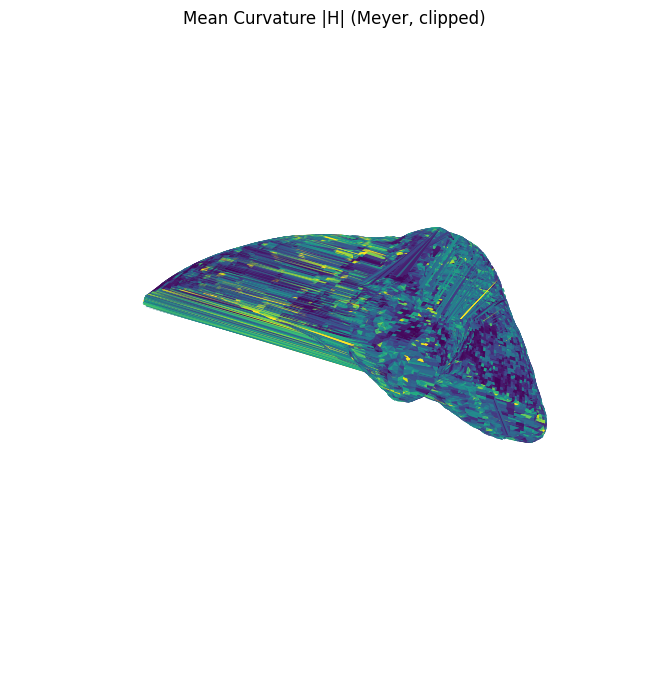

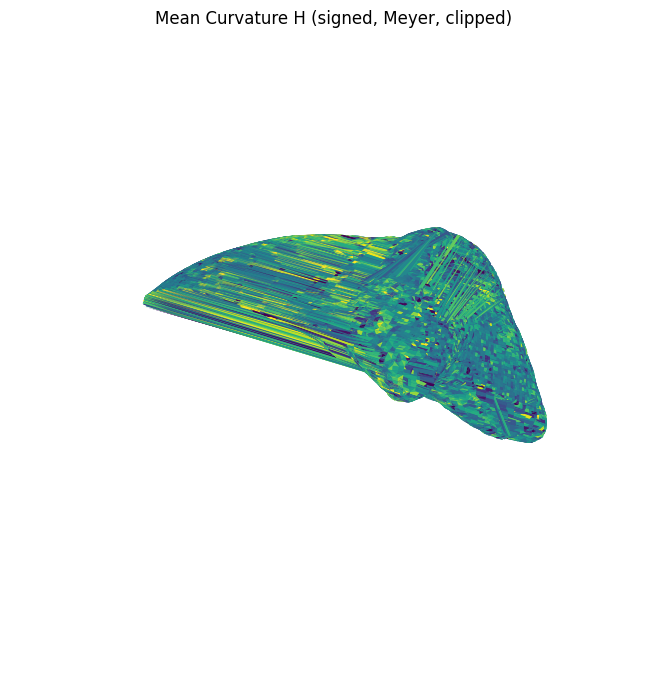

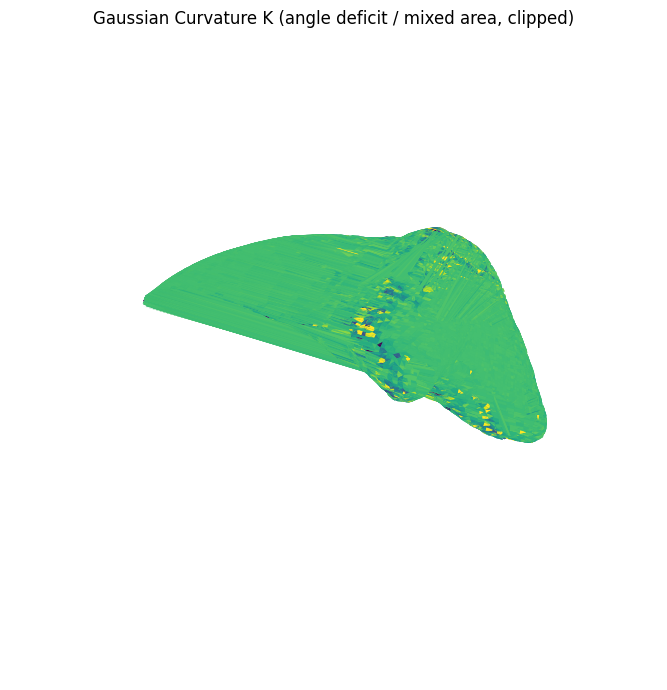

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def normalize_for_colormap(values, q_low=0.02, q_high=0.98):
    v = np.asarray(values, float)
    lo = np.quantile(v, q_low)
    hi = np.quantile(v, q_high)
    v = np.clip(v, lo, hi)
    v = (v - v.min()) / (v.max() - v.min() + 1e-12)
    return v

def plot_vertex_scalar_on_surface(V, F, values, title, q_low=0.02, q_high=0.98):
    values = np.asarray(values, float)
    face_vals = values[F].mean(axis=1)               # per-face scalar
    c = normalize_for_colormap(face_vals, q_low, q_high)
    face_colors = cm.viridis(c)

    faces_xyz = V[F]
    fig = plt.figure(figsize=(8, 7))
    ax = fig.add_subplot(111, projection="3d")
    poly = Poly3DCollection(faces_xyz, facecolors=face_colors, linewidth=0.0)
    poly.set_edgecolor((0,0,0,0))
    ax.add_collection3d(poly)
    ax.auto_scale_xyz(V[:,0], V[:,1], V[:,2])
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

import numpy as np

# ------------------------------------------------------------
# Helper: angle at vertex b in triangle (a, b, c)
# ------------------------------------------------------------
def tri_angle(a, b, c, eps=1e-15):
    ba = a - b
    bc = c - b
    dot = np.einsum("ij,ij->i", ba, bc)
    n1 = np.linalg.norm(ba, axis=1)
    n2 = np.linalg.norm(bc, axis=1)
    cosv = dot / (n1 * n2 + eps)
    return np.arccos(np.clip(cosv, -1.0, 1.0))


# ------------------------------------------------------------
# Mixed Voronoi area (Meyer et al. 2003)
# ------------------------------------------------------------
def mixed_voronoi_area(V, F):
    V = np.asarray(V, float)
    F = np.asarray(F, int)

    v0 = V[F[:, 0]]
    v1 = V[F[:, 1]]
    v2 = V[F[:, 2]]

    # edge vectors
    e0 = v1 - v0
    e1 = v2 - v1
    e2 = v0 - v2

    l0 = np.linalg.norm(e0, axis=1)
    l1 = np.linalg.norm(e1, axis=1)
    l2 = np.linalg.norm(e2, axis=1)

    A0 = tri_angle(v1, v0, v2)
    A1 = tri_angle(v2, v1, v0)
    A2 = tri_angle(v0, v2, v1)

    face_area = 0.5 * np.linalg.norm(np.cross(e0, -e2), axis=1)

    obt0 = A0 > np.pi / 2
    obt1 = A1 > np.pi / 2
    obt2 = A2 > np.pi / 2
    any_obt = obt0 | obt1 | obt2

    cot0 = 1.0 / np.tan(A0)
    cot1 = 1.0 / np.tan(A1)
    cot2 = 1.0 / np.tan(A2)

    area0 = np.zeros(len(F))
    area1 = np.zeros(len(F))
    area2 = np.zeros(len(F))

    # non-obtuse
    mask = ~any_obt
    area0[mask] = (l2[mask]**2 * cot1[mask] + l1[mask]**2 * cot2[mask]) * 0.125
    area1[mask] = (l0[mask]**2 * cot2[mask] + l2[mask]**2 * cot0[mask]) * 0.125
    area2[mask] = (l1[mask]**2 * cot0[mask] + l0[mask]**2 * cot1[mask]) * 0.125

    # obtuse cases
    area0[obt0] = face_area[obt0] * 0.5
    area1[obt0] = face_area[obt0] * 0.25
    area2[obt0] = face_area[obt0] * 0.25

    area1[obt1] = face_area[obt1] * 0.5
    area2[obt1] = face_area[obt1] * 0.25
    area0[obt1] = face_area[obt1] * 0.25

    area2[obt2] = face_area[obt2] * 0.5
    area0[obt2] = face_area[obt2] * 0.25
    area1[obt2] = face_area[obt2] * 0.25

    A = np.zeros(len(V))
    np.add.at(A, F[:, 0], area0)
    np.add.at(A, F[:, 1], area1)
    np.add.at(A, F[:, 2], area2)

    return A


# ------------------------------------------------------------
# Gaussian curvature (angle deficit + mixed area)
# ------------------------------------------------------------
def gaussian_curvature_angle_deficit_mixed_area(V, F):
    V = np.asarray(V, float)
    F = np.asarray(F, int)

    p0 = V[F[:, 0]]
    p1 = V[F[:, 1]]
    p2 = V[F[:, 2]]

    A0 = tri_angle(p1, p0, p2)
    A1 = tri_angle(p2, p1, p0)
    A2 = tri_angle(p0, p2, p1)

    nV = V.shape[0]
    angle_sum = (
        np.bincount(F[:, 0], A0, minlength=nV) +
        np.bincount(F[:, 1], A1, minlength=nV) +
        np.bincount(F[:, 2], A2, minlength=nV)
    )

    A_mixed = mixed_voronoi_area(V, F)
    K = (2.0 * np.pi - angle_sum) / (A_mixed + 1e-12)
    return K

# ------------------------------------------------------------
# Mean curvature via cotangent Laplace–Beltrami (Meyer 2003)
# ------------------------------------------------------------
def mean_curvature_meyer(V, F, signed=True):
    V = np.asarray(V, float)
    F = np.asarray(F, int)
    nV = V.shape[0]

    p0 = V[F[:, 0]]
    p1 = V[F[:, 1]]
    p2 = V[F[:, 2]]

    def cot(u, v, eps=1e-15):
        return np.einsum("ij,ij->i", u, v) / (
            np.linalg.norm(np.cross(u, v), axis=1) + eps
        )

    cot0 = cot(p1 - p0, p2 - p0)
    cot1 = cot(p2 - p1, p0 - p1)
    cot2 = cot(p0 - p2, p1 - p2)

    A = mixed_voronoi_area(V, F)

    L = np.zeros_like(V)

    for i, (i0, i1, i2) in enumerate(F):
        L[i0] += cot1[i] * (V[i2] - V[i0]) + cot2[i] * (V[i1] - V[i0])
        L[i1] += cot2[i] * (V[i0] - V[i1]) + cot0[i] * (V[i2] - V[i1])
        L[i2] += cot0[i] * (V[i1] - V[i2]) + cot1[i] * (V[i0] - V[i2])

    # Mean curvature normal
    Hn = L / (2.0 * (A[:, None] + 1e-12))

    H_mag = np.linalg.norm(Hn, axis=1)

    if not signed:
        return Hn, H_mag, None

    # vertex normals (area weighted)
    FN = np.cross(p1 - p0, p2 - p0)
    VN = np.zeros_like(V)
    for k in range(3):
        np.add.at(VN, F[:, k], FN)
    VN /= np.linalg.norm(VN, axis=1, keepdims=True) + 1e-12

    sign = np.sign(np.einsum("ij,ij->i", Hn, VN))
    H_signed = sign * H_mag

    return Hn, H_mag, H_signed

K = gaussian_curvature_angle_deficit_mixed_area(V30, F30)
Hn, H_mag, H_signed = mean_curvature_meyer(V30, F30, signed=True)

plot_vertex_scalar_on_surface(V30, F30, H_mag, "Mean Curvature |H| (Meyer, clipped)")
plot_vertex_scalar_on_surface(V30, F30, H_signed, "Mean Curvature H (signed, Meyer, clipped)")
plot_vertex_scalar_on_surface(V30, F30, K, "Gaussian Curvature K (angle deficit / mixed area, clipped)")